In [1]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 KB 9.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron

In [3]:
df=pd.read_csv("euro.csv") #loading the file 

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y') #converting date column "str" to "datetime" object
df.set_index('Date', inplace=True)

In [5]:
df.head(5) #printing top-5 data on the table

,EURO
Date,
2016-04-04,75.3713
2016-04-05,75.5240
2016-04-06,75.6290
2016-04-07,75.8952
2016-04-11,75.7538


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 788 entries, 2016-04-04 to 2023-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EURO    788 non-null    float64
dtypes: float64(1)
memory usage: 12.3 KB


In [7]:
df.describe() # prinitng basic Data statistics 

,EURO
count,788.000000
mean,77.765828
std,5.069230
min,68.250300
25%,74.216875
50%,76.521850
75%,80.691400
max,90.255500


<Axes: xlabel='Date'>

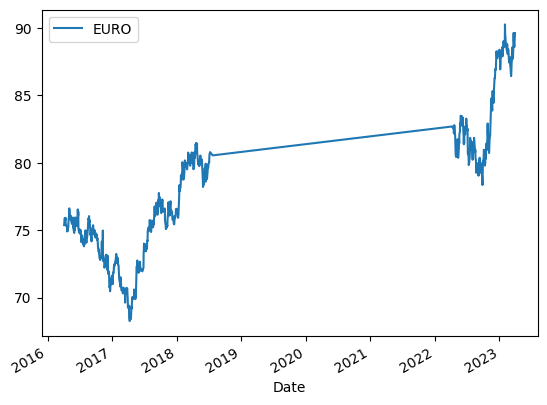

In [8]:
df.plot()

### Filtering data for range April-2016 till April-2018

In [9]:
mmr1= df.loc['2022-1-1':'2023-1-1'] #filtering data for 2022-1-1 till 2023-1-1

<Axes: xlabel='Date'>

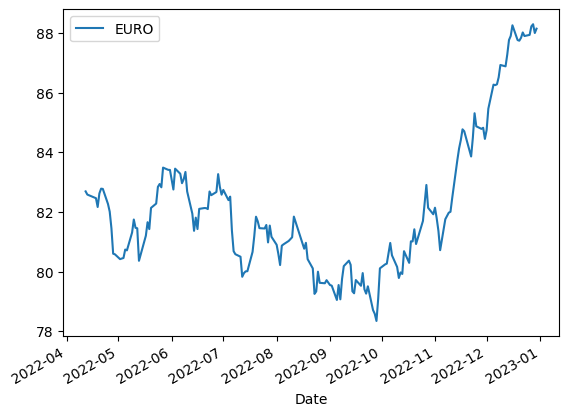

In [10]:
mmr1.plot()

## Statistical test

### 1. Augmented Dickey-Fuller test

In [11]:
result = adfuller(mmr1) #augmented Dickey-Fuller test
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.070607
p-value: 0.952289
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


### 2. Phillips Perron test

In [12]:
PhillipsPerron(mmr1)

Test Statistic,0.083
P-value,0.965
Lags,14


Since ADF test statistic is negative and p-value is higher we cannot reject the null of unit root and PP test is rehecting the null hypothesis, hence data is non-stationary

time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

### First Difference of mmr1

In [13]:
dmmr1 = mmr1.diff()

In [14]:
dmmr1.iloc[0]=mmr1.iloc[0]

In [15]:
result = adfuller(dmmr1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.422414
p-value: 0.000271
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


In [16]:
PhillipsPerron(dmmr1)

Test Statistic,-191.279
P-value,0.000
Lags,14


### After taking first diffrenec the data is stationary

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot

### Plotting Auto-correlation function

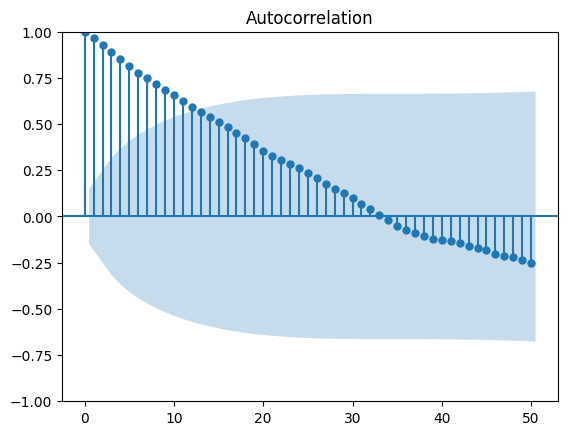

In [18]:
plot_acf(mmr1,lags=50) #plotting autocorrelation at First Difference 
pyplot.show()

We are getting positive auto-correlation at 30th lagsignificant for the first 10 lags.

A good starting point for the AR parameter of the model may be 10

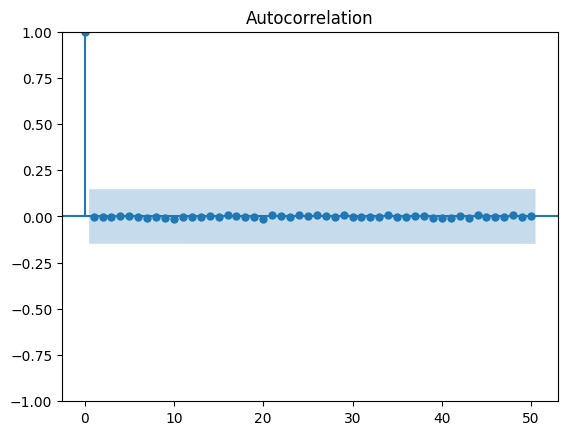

In [19]:
plot_acf(dmmr1,lags=50) #plotting autocorelation of first difference
pyplot.show()

### Plotting Partial Auto-Correlation function

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


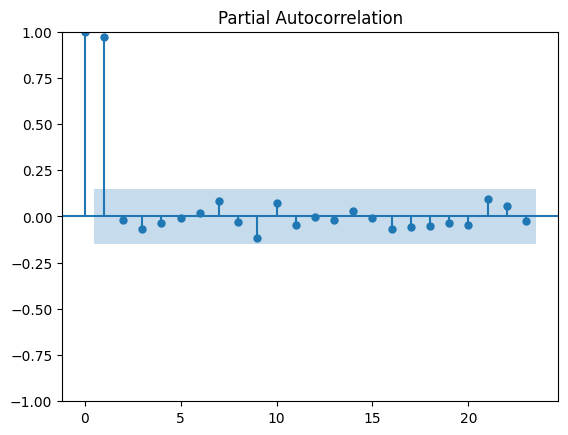

In [21]:
plot_pacf(mmr1) #partial Autocorrelation of actual series
pyplot.show()

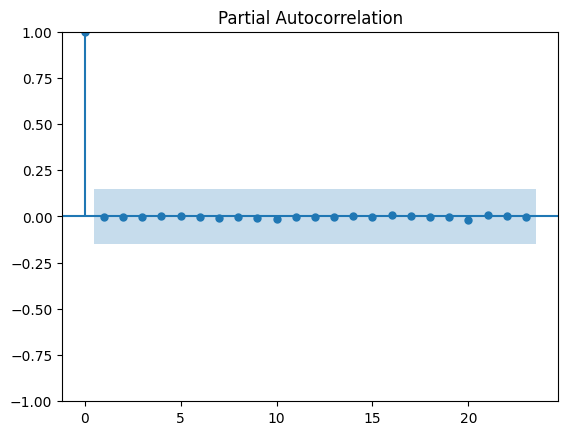

In [22]:
plot_pacf(dmmr1) #Partial Auto-Correlation of First Difference
pyplot.show()

Since ACF plot shows that Auto-correlation is dropping immediately after first lag and we can use ARIM 

# ARIMA Models

In [23]:
from statsmodels.tsa.arima.model import ARIMA #loading ARIMA model in python

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   EURO   No. Observations:                  176
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -113.331
Date:                Sun, 02 Apr 2023   AIC                            238.661
Time:                        06:02:26   BIC                            257.650
Sample:                             0   HQIC                           246.364
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0237      0.069      0.341      0.733      -0.112       0.160
ar.L2          0.0247      0.088      0.280      0.779      -0.148       0.198
ar.L3          0.0317      0.088      0.359      0.7

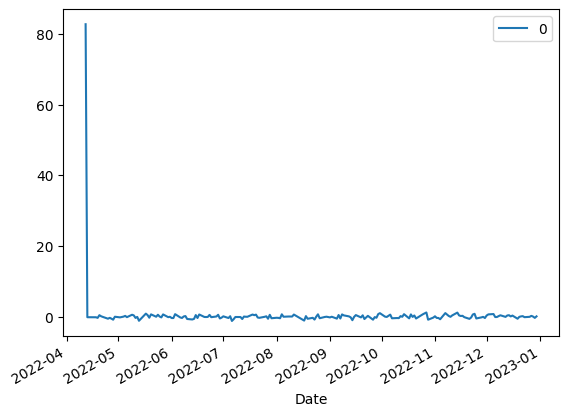

In [24]:
model = ARIMA(mmr1, order=(5,1,0)) #initialisation of ARIMA model
model_fit = model.fit() # model fitting 
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

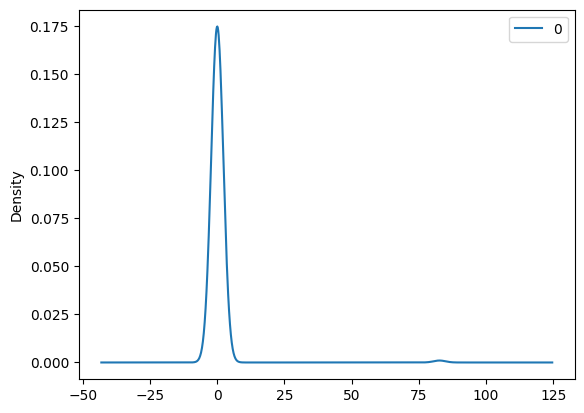

In [25]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

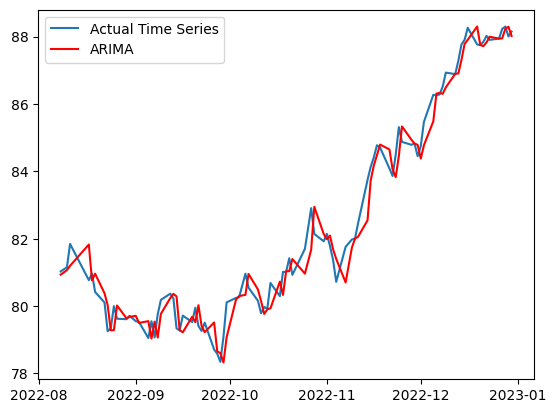

In [26]:
import matplotlib.pyplot as plt
plt.plot(mmr1[80:],label="Actual Time Series")
plt.plot(model_fit.fittedvalues[80:], color='red',label="ARIMA")
plt.legend()

## First period ahead value Forcasting for Feb-2023

In [27]:
test = df.loc['2023-1-1':'2023-1-15'][:10]
test.head(10)

,EURO
Date,
2023-01-02,88.3753
2023-01-03,88.2508
2023-01-04,87.6546
2023-01-05,87.7992
2023-01-06,86.9235
2023-01-09,87.9528
2023-01-10,88.2829
2023-01-11,87.8551
2023-01-12,87.9566


In [28]:
predicted = []
predicted2 = []
for i in range(0,10): #Rolling Forecast ARIMA model
  mmr1= df.loc['2022-1-1':f'2023-1-{1+i}'] 
  # # fit model
  model = ARIMA(mmr1, order=(5,1,0)) #-> ARIMA model 1
  model_fit = model.fit()
  predicted.append(model_fit.forecast(steps=1).to_list()[0]) #First period ahead forecast for Model1 

  #prediction by model 2
  model2 = ARIMA(mmr1, order=(10,1,0)) #-> ARIMA model 2
  model_fit2 = model2.fit()
  predicted2.append(model_fit2.forecast(steps=1).to_list()[0]) #First period ahead forecast for Model1 
  
  

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/pytho

In [29]:
test['Model 1 predicted']=predicted
test['Model 2 predicted']=predicted2

In [30]:
test

,EURO,Model 1 predicted,Model 2 predicted
Date,,,
2023-01-02,88.3753,88.150863,88.195150
2023-01-03,88.2508,88.357854,88.371293
2023-01-04,87.6546,88.247153,88.160069
2023-01-05,87.7992,87.666760,87.674117
2023-01-06,86.9235,87.783660,87.857475
2023-01-09,87.9528,86.871424,86.802108
2023-01-10,88.2829,86.871424,86.802108
2023-01-11,87.8551,86.871424,86.802108
2023-01-12,87.9566,87.916897,87.783534


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test['EURO'],test['predicted']) #MSPE for Model 1

0.006269505931084722

In [220]:
mean_absolute_percentage_error(test['EURO'],test['predicted2']) #MSPE for Model 2

0.006781108218092335

In [221]:
# !pip install dieboldmariano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Debol Mariano Test

In [222]:
from dieboldmariano import dm_test

In [224]:
dm_test(test["EURO"], test['predicted'], test['predicted2'], one_sided=True)

(-2.0061652704341872, 0.03789774276997642)

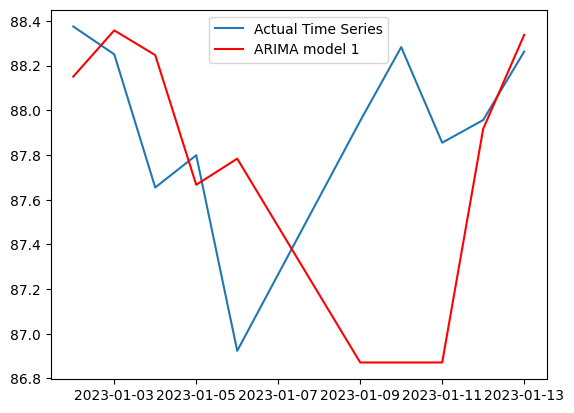

In [32]:
import matplotlib.pyplot as plt
plt.plot(test['EURO'],label="Actual Time Series")
plt.plot(test['Model 1 predicted'], color='red',label="ARIMA model 1")
plt.legend()